3D-объём: (512, 512, 121)
Voxel size: [0.52734375, 0.52734375, 3.0]


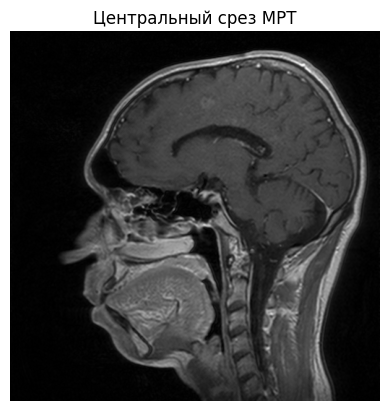

In [2]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from collections import Counter

DATA_PATH = r"C:\DIPLOM\dicom_im1"
file_names = sorted([f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f))])

# Загружаем только DICOM с PixelData
slices = []
for f in file_names:
    try:
        ds = pydicom.dcmread(os.path.join(DATA_PATH, f))
        if 'PixelData' in ds:
            slices.append(ds)
    except Exception:
        pass

if not slices:
    raise ValueError("Нет файлов с изображением.")

# Сортировка по InstanceNumber
slices.sort(key=lambda x: int(getattr(x, "InstanceNumber", 0)))

# Фильтрация по форме изображения
shapes = [s.pixel_array.shape for s in slices]
most_common_shape, _ = Counter(shapes).most_common(1)[0]
slices = [s for s in slices if s.pixel_array.shape == most_common_shape]

# Получение voxel size
pixel_spacing = slices[0].PixelSpacing
slice_thickness = slices[0].SliceThickness
voxel_size = [float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)]

# Сборка 3D объёма
image_3d = np.stack([s.pixel_array for s in slices], axis=-1).astype(np.int16)

print("3D-объём:", image_3d.shape)
print("Voxel size:", voxel_size)

# Визуализация центрального среза
plt.imshow(image_3d[:, :, image_3d.shape[2] // 2], cmap="gray")
plt.title("Центральный срез МРТ")
plt.axis("off")
plt.show()


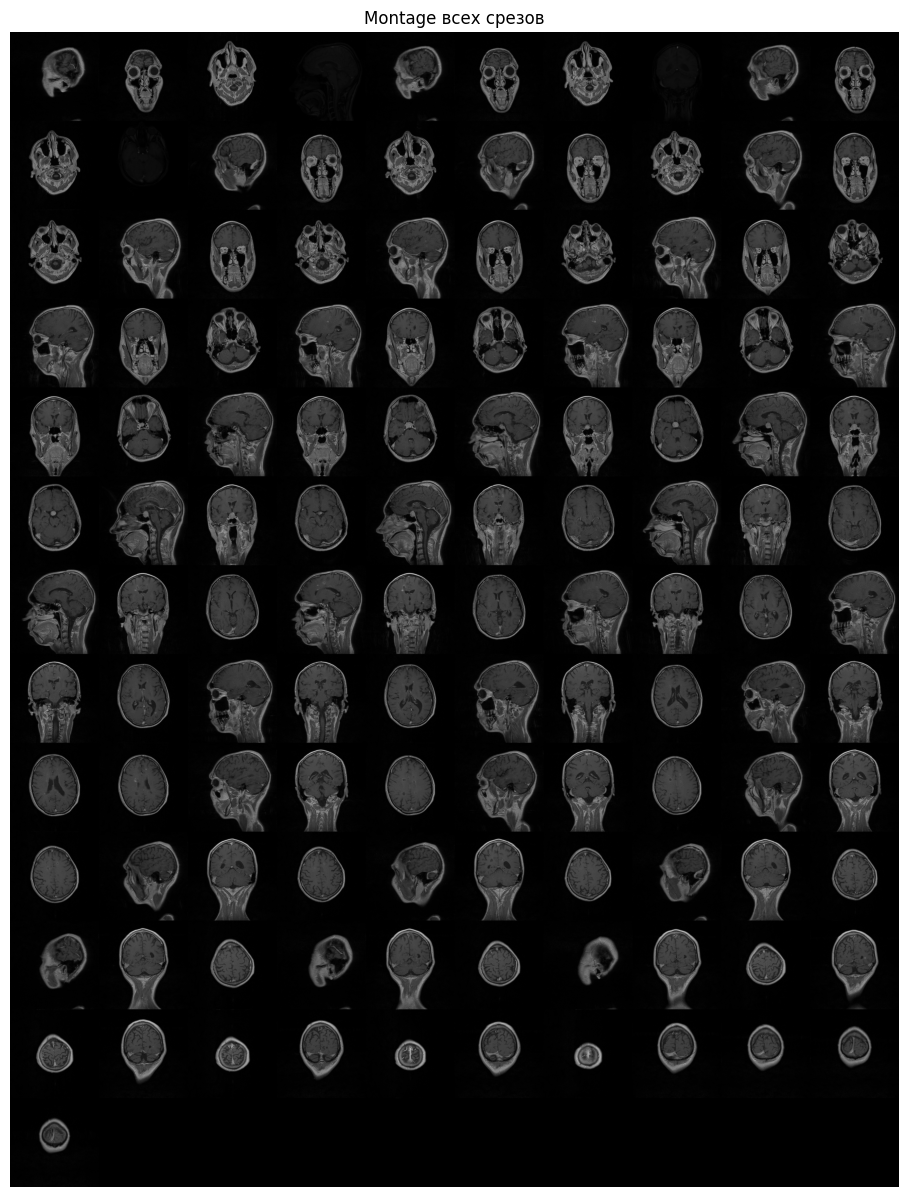

In [3]:
def show_montage(volume, cols=10):
    """Показать montage из 3D-объёма"""
    num_slices = volume.shape[2]
    rows = int(np.ceil(num_slices / cols))
    montage = np.zeros((rows * volume.shape[0], cols * volume.shape[1]), dtype=volume.dtype)

    for i in range(num_slices):
        row = i // cols
        col = i % cols
        montage[
            row * volume.shape[0]:(row + 1) * volume.shape[0],
            col * volume.shape[1]:(col + 1) * volume.shape[1]
        ] = volume[:, :, i]

    plt.figure(figsize=(15, 15))
    plt.imshow(montage, cmap='gray')
    plt.title("Montage всех срезов")
    plt.axis("off")
    plt.show()

# Вызов функции
show_montage(image_3d, cols=10)


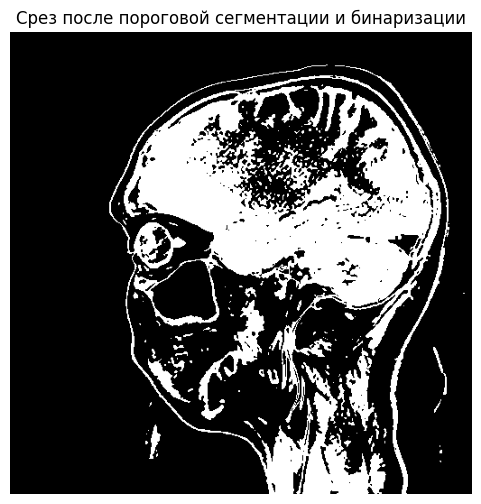

In [31]:
# Пороговая сегментация
threshold_lower = 300
threshold_upper = 900

segmented = np.copy(image_3d)
segmented[segmented <= threshold_lower] = 0
segmented[segmented >= threshold_upper] = 0

# Аналог: SegmentedBrainMRI(175:end,:,:) = 0
# Обнуляем всё, что выше 175-го среза (вдоль оси Z)
if segmented.shape[2] > 175:
    segmented[:, :, 175:] = 0

# Перевод в бинарную маску
binary_mask = segmented > 0

# Визуализация результата
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask[:, :, 30], cmap='gray')
plt.title("Срез после пороговой сегментации и бинаризации")
plt.axis("off")
plt.show()


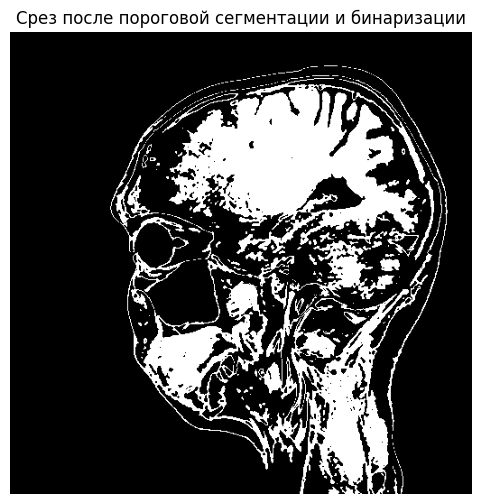

In [85]:
# Пороговая сегментация
threshold_lower = 800
threshold_upper = 1200

segmented = np.copy(image_3d)
segmented[segmented <= threshold_lower] = 0
segmented[segmented >= threshold_upper] = 0

# Аналог: SegmentedBrainMRI(175:end,:,:) = 0
# Обнуляем всё, что выше 175-го среза (вдоль оси Z)
if segmented.shape[2] > 100:
    segmented[:, :, 100:] = 0

# Перевод в бинарную маску
binary_mask = segmented > 0

# Визуализация результата
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask[:, :, 30], cmap='gray')
plt.title("Срез после пороговой сегментации и бинаризации")
plt.axis("off")
plt.show()


In [76]:
threshold_pixels = 100  # например
active_slices = [i for i, cnt in enumerate(nonzeros) if cnt > threshold_pixels]
z_min, z_max = min(active_slices), max(active_slices)
print("Мозг присутствует на срезах", z_min, "…", z_max)


Мозг присутствует на срезах 0 … 120


Используем порог: 584.1 (otsu)


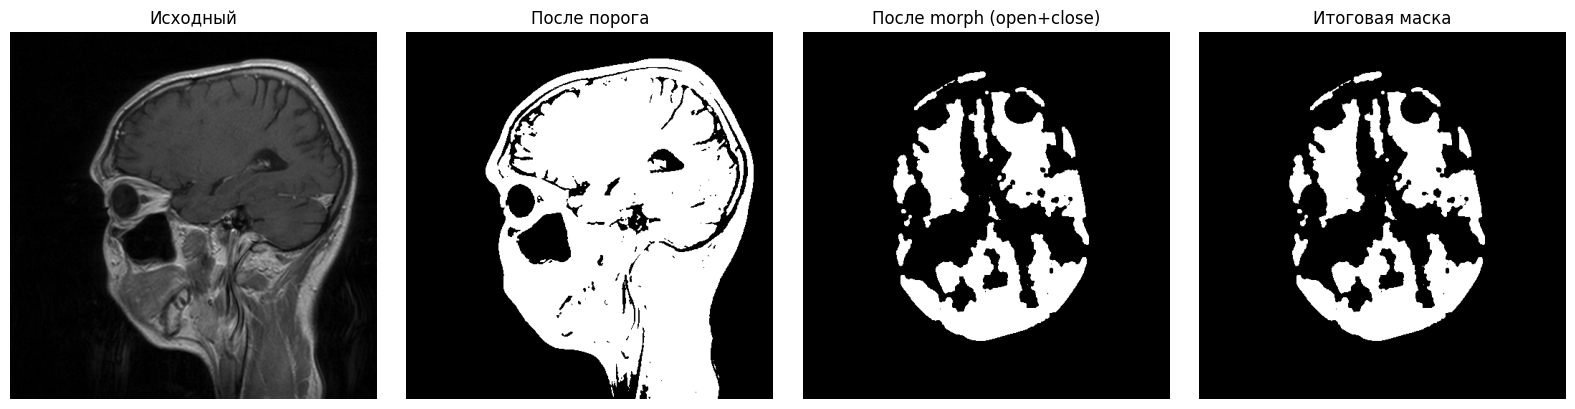

In [94]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt

import SimpleITK as sitk
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, ball
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from scipy.ndimage import binary_fill_holes
from collections import Counter

# -----------------------------------------
#          НАСТРОЙКИ ПАЙПЛАЙНА
# -----------------------------------------
DATA_PATH           = r"C:\DIPLOM\dicom_im1"
SLICE_MIN, SLICE_MAX = 0, 60        # работаем только с этими срезами по Z
USE_BIAS_CORR       = False           # включить N4 bias-field коррекцию
N4_ITERS            = 20            # число итераций для N4
THRESH_METHOD       = 'otsu'         # 'otsu' или 'manual'
MANUAL_THRESH       = 900            # если THRESH_METHOD='manual'
OPEN_RAD            = 3              # радиус для opening (ball)
CLOSE_RAD           = 3              # радиус для closing
# -----------------------------------------

# 1) Чтение DICOM и сборка 3D-объёма (как у тебя уже в коде)
file_names = sorted(f for f in os.listdir(DATA_PATH)
                    if os.path.isfile(os.path.join(DATA_PATH, f)))
slices = []
for f in file_names:
    try:
        ds = pydicom.dcmread(os.path.join(DATA_PATH, f))
        if 'PixelData' in ds:
            slices.append(ds)
    except:
        pass
# сортируем и фильтруем по единой форме
slices.sort(key=lambda x: int(getattr(x, "InstanceNumber", 0)))
shape_counts = Counter([s.pixel_array.shape for s in slices])
common_shape = shape_counts.most_common(1)[0][0]
slices = [s for s in slices if s.pixel_array.shape == common_shape]
image_3d = np.stack([s.pixel_array for s in slices], axis=-1).astype(np.float32)

# 2) Обрезка по срезам 0…120
image_3d[:,:, :SLICE_MIN] = 0
if image_3d.shape[2] > SLICE_MAX:
    image_3d[:,:, SLICE_MAX+1:] = 0

# 3) (Опционально) N4 bias-field correction
if USE_BIAS_CORR:
    sitk_img = sitk.GetImageFromArray(image_3d.transpose(2,1,0))
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([N4_ITERS])
    corrected = corrector.Execute(sitk_img)
    image_3d = sitk.GetArrayFromImage(corrected).transpose(2,1,0)

# 4) Пороговая сегментация
if THRESH_METHOD == 'otsu':
    # считаем только ненулевые воксели
    voxels = image_3d[image_3d>0]
    thresh = threshold_otsu(voxels)
else:
    thresh = MANUAL_THRESH
print(f"Используем порог: {thresh:.1f} ({THRESH_METHOD})")

# Применяем: всё ниже thresh = фон
seg = np.copy(image_3d)
seg[seg <= thresh] = 0
binary = seg > 0

# 5) Морфология: opening → closing → заполнение дыр → clear_border
selem_o = ball(OPEN_RAD)
selem_c = ball(CLOSE_RAD)
opened = opening(binary, selem_o)
closed = closing(opened, selem_c)
filled = binary_fill_holes(closed)
clean = clear_border(filled)

# 6) Выбираем самый большой компонент
lbl = label(clean)
props = regionprops(lbl)
largest = max(props, key=lambda p: p.area).label
brain_mask = (lbl == largest)

# 7) Визуализация промежуточных и итоговой маски
slice_idx = (SLICE_MAX - SLICE_MIN) // 2 + SLICE_MIN
fig, axs = plt.subplots(1, 4, figsize=(16,4))

axs[0].imshow(image_3d[:,:,slice_idx], cmap='gray')
axs[0].set_title("Исходный (после N4)" if USE_BIAS_CORR else "Исходный")
axs[1].imshow(binary[:,:,slice_idx], cmap='gray')
axs[1].set_title("После порога")
axs[2].imshow(clean[:,:,slice_idx], cmap='gray')
axs[2].set_title("После morph (open+close)")
axs[3].imshow(brain_mask[:,:,slice_idx], cmap='gray')
axs[3].set_title("Итоговая маска")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()
